## Scaling - LightGBM

In [0]:
# Install the lightgbm package for gradient boosting framework
# Install the SeqMetrics package for sequence metric calculations
# Install the easy_mpl package for simplified matplotlib plotting
%pip install lightgbm SeqMetrics easy_mpl
%pip install sdv
%pip install optuna optuna-integration

  Using cached SeqMetrics-2.0.0-py3-none-any.whl
  Using cached easy_mpl-0.21.4-py3-none-any.whl
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for sdv from https://files.pythonhosted.org/packages/10/57/73addd935aaed14596ea796ca7503252d7a679b9a8f08b8277757db7cdb7/sdv-1.18.0-py3-none-any.whl.metadata
  Using cached sdv-1.18.0-py3-none-any.whl.metadata (13 kB)
  Obtaining dependency information for graphviz>=0.13.2 from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for copulas>=0.12.0 from https://files.pythonhosted.org/packages/e3/fa/16b0f4091ad862c91ebb82273f4f0d34a914d2844d79ea1096b8bd1a20d0/copulas-0.12.1-py3-none-any.whl.metadata
  Using cached copulas-0.12.1-py3-none-any.wh

In [0]:
dbutils.library.restartPython()

#### Loading the dataset

In [0]:
from pyspark import SparkFiles
import urllib

DATASET_FILE = "ts-spark_ch7_ds1_25mb.csv"
DATASET_URL = f"https://github.com/PacktPublishing/Time-Series-Analysis-with-Spark/raw/main/ch7/{DATASET_FILE}"

# Load the main dataset from a specified path with headers, custom date format, and delimiter
print(f"Ingesting from: {DATASET_URL}")

# option 1 - using sparkContext
#spark.sparkContext.addFile(DATASET_URL)
#df_main = spark.read.csv("file:///" + SparkFiles.get(DATASET_FILE), header=True, dateFormat='yyyy-MM-dd', sep=";")
# option 2 - using urllib
urllib.request.urlretrieve(DATASET_URL, f"/tmp/{DATASET_FILE}")
dbutils.fs.cp(f"file:/tmp/{DATASET_FILE}", f"dbfs:/tmp/{DATASET_FILE}")
df_main = spark.read.csv(f"dbfs:/tmp/{DATASET_FILE}", header=True, dateFormat='yyyy-MM-dd', sep=";")
#

df_main.cache()

Ingesting from: https://github.com/PacktPublishing/Time-Series-Analysis-with-Spark/raw/main/ch7/ts-spark_ch7_ds1_25mb.csv


DataFrame[Date: string, Time: string, Global_active_power: string, Global_reactive_power: string, Voltage: string, Global_intensity: string, Sub_metering_1: string, Sub_metering_2: string, Sub_metering_3: string]

##### Scaled-up dataset (book section)

In [0]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

# Convert Spark DataFrame to Pandas DataFrame for compatibility with SDV
pdf_main = df_main.toPandas()

# Initialize metadata object for the dataset
metadata = SingleTableMetadata()

# Automatically detect and set the metadata from the Pandas DataFrame
metadata.detect_from_dataframe(pdf_main)

# Initialize the Gaussian Copula Synthesizer with the dataset metadata
synthesizer = GaussianCopulaSynthesizer(metadata)

# Fit the synthesizer model to the Pandas DataFrame
synthesizer.fit(pdf_main)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-eac5e441-dc88-41b0-a5b9-be05a113aeda/lib/python3.11/site-packages/sdv/single_table/base.py:119: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-eac5e441-dc88-41b0-a5b9-be05a113aeda/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [0]:
from pyspark.sql import functions as F

num_customers = 5  # Define the number of customer datasets to generate
sample_size = df_main.count()  # Count the number of rows in the original dataset

i = 1
df_all = df_main.withColumn('cust_id', F.lit(i))  # Add a 'cust_id' column to the original dataset with a constant value of 1
for i in range(i+1, num_customers+1):  # Loop to generate synthetic data for additional customers
    synthetic_data = spark.createDataFrame(synthesizer.sample(num_rows=sample_size))  # Generate synthetic data matching the original dataset's size
    synthetic_data = synthetic_data.withColumn('cust_id', F.lit(i))  # Add a 'cust_id' column to the synthetic data with a unique value for each customer
    df_all = df_all.union(synthetic_data)  # Append the synthetic data to the aggregated DataFrame

df_all.cache()  # Cache the resulting DataFrame to optimize subsequent actions

DataFrame[Date: string, Time: string, Global_active_power: string, Global_reactive_power: string, Voltage: string, Global_intensity: string, Sub_metering_1: string, Sub_metering_2: string, Sub_metering_3: string, cust_id: int]

#### Data Preparation

##### Column transformations (book section)

In [0]:
from pyspark.sql import functions as F

# Combine 'Date' and 'Time' into a single 'Date' column of timestamp type
df_all = df_all.withColumn(
    'Date',
    F.to_timestamp(F.concat_ws(' ', F.col('Date'), F.col('Time')), 'd/M/yyyy HH:mm:ss')
)

# Drop the now redundant 'Time' column
df_all = df_all.drop('Time')

# Select only the 'cust_id', 'Date' and 'Global_active_power' columns
df_all = df_all.select('cust_id', 'Date', 'Global_active_power')

# Replace '?' with None and convert 'Global_active_power' to float
df_all = df_all.withColumn(
    'Global_active_power',
    F.when(F.col('Global_active_power') == '?', None)
    .otherwise(F.regexp_replace('Global_active_power', ',', '.').cast('float'))
)

# Sort the DataFrame based on 'cust_id' and 'Date'
df_all = df_all.orderBy('cust_id', 'Date')

##### Resampling (book section)

In [0]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Convert the 'Date' column to a string representing the start of the hour for each timestamp
data_hr = df_all.withColumn('Date', F.date_format('Date', 'yyyy-MM-dd HH:00:00'))

# Group the data by 'cust_id' and the hourly 'Date', then calculate the mean 'Global_active_power' for each group
data_hr = data_hr.groupBy('cust_id', 'Date').agg(F.mean('Global_active_power').alias('Global_active_power'))

##### Calculating lag values (book section)

In [0]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define a window specification partitioned by 'cust_id' and ordered by the 'Date' column
windowSpec = Window.partitionBy("cust_id").orderBy("Date")

# Add lagged features to the DataFrame to incorporate past values as features for forecasting
# Apply the lag function to create the lagged column, separately for each 'cust_id'
# Lag by 1, 2, 3, 4, 5, 12, 24, 168 hours (24 hours * 7 days)
lags = [1, 2, 3, 4, 5, 12, 24, 24*7]
for l in lags:
    data_hr = data_hr.withColumn('Global_active_power_lag' + str(l), F.lag(F.col('Global_active_power'), l).over(windowSpec))

# Remove rows with NaN values that were introduced by shifting (lagging) operations
data_hr = data_hr.dropna()
data_hr.cache()

DataFrame[cust_id: int, Date: string, Global_active_power: double, Global_active_power_lag1: double, Global_active_power_lag2: double, Global_active_power_lag3: double, Global_active_power_lag4: double, Global_active_power_lag5: double, Global_active_power_lag12: double, Global_active_power_lag24: double, Global_active_power_lag168: double]

In [0]:
# Split the data into training and testing sets
# The last 48 observations are used for testing, the rest for training
train_pdf = data_hr.filter('cust_id == 1').toPandas()
train = train_pdf[:-48]
test = train_pdf[-48:]

In [0]:
# Define the feature set for training based on lagged values of global active power
X_train = train[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']] 
# Define the target variable for the training set
y_train = train['Global_active_power']

X_test = test[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
y_test = test['Global_active_power']

#### Experiment 1 - Optuna, LightGBM

##### Hyperparameter tuning (book section)

In [0]:
import joblib
import optuna

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna

def objective(trial):
    # Define the hyperparameter configuration space
    params = {
        "objective": "regression",  # Specify the learning task and the corresponding learning objective
        "metric": "rmse",  # Evaluation metric for the model performance
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Number of boosted trees to fit
         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),  # Learning rate for gradient descent
        "num_leaves": trial.suggest_int("num_leaves", 30, 100),  # Maximum tree leaves for base learners
    }

    model = lgb.LGBMRegressor(**params)  # Initialize the LightGBM model with the trial's parameters
    model.fit(X_train, y_train)  # Train the model with the training dataset
    y_pred = model.predict(X_test)  # Generate predictions for the test dataset
    mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculate the Mean Absolute Percentage Error (MAPE) for model evaluation
    return mape  # Return the MAPE as the objective to minimize

In [0]:
# Initialize an Optuna study object for hyperparameter optimization, aiming to minimize the objective function
study = optuna.create_study(direction='minimize')
# Execute the optimization process by calling the objective function with the study object, for a specified number of trials
study.optimize(objective, n_trials=10)

[I 2025-03-01 01:16:13,837] A new study created in memory with name: no-name-1e097228-3f67-4dbd-9775-03f3a1393a1c


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:16:23,140] Trial 0 finished with value: 0.6065672398221539 and parameters: {'n_estimators': 71, 'learning_rate': 0.012523257301148075, 'num_leaves': 34}. Best is trial 0 with value: 0.6065672398221539.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:16:30,458] Trial 1 finished with value: 0.5402655624222814 and parameters: {'n_estimators': 163, 'learning_rate': 0.010732556397408154, 'num_leaves': 62}. Best is trial 1 with value: 0.5402655624222814.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:16:37,603] Trial 2 finished with value: 0.8058101235117631 and parameters: {'n_estimators': 116, 'learning_rate': 0.0012527155362543696, 'num_leaves': 77}. Best is trial 1 with value: 0.5402655624222814.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:16:44,367] Trial 3 finished with value: 0.5957279110444931 and parameters: {'n_estimators': 52, 'learning_rate': 0.018062616075888726, 'num_leaves': 64}. Best is trial 1 with value: 0.5402655624222814.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:16:51,236] Trial 4 finished with value: 0.7837975793900783 and parameters: {'n_estimators': 185, 'learning_rate': 0.0010612325067600244, 'num_leaves': 70}. Best is trial 1 with value: 0.5402655624222814.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:16:58,070] Trial 5 finished with value: 0.5373855111092559 and parameters: {'n_estimators': 86, 'learning_rate': 0.022669276196881964, 'num_leaves': 44}. Best is trial 5 with value: 0.5373855111092559.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:05,265] Trial 6 finished with value: 0.5301133871565731 and parameters: {'n_estimators': 142, 'learning_rate': 0.02240933323143113, 'num_leaves': 99}. Best is trial 6 with value: 0.5301133871565731.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:12,045] Trial 7 finished with value: 0.5504822832003772 and parameters: {'n_estimators': 170, 'learning_rate': 0.008998820968059476, 'num_leaves': 58}. Best is trial 6 with value: 0.5301133871565731.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:18,453] Trial 8 finished with value: 0.6480070103046073 and parameters: {'n_estimators': 65, 'learning_rate': 0.009768057153075575, 'num_leaves': 62}. Best is trial 6 with value: 0.5301133871565731.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:25,154] Trial 9 finished with value: 0.7505641782055733 and parameters: {'n_estimators': 96, 'learning_rate': 0.0028265053746267003, 'num_leaves': 50}. Best is trial 6 with value: 0.5301133871565731.


In [0]:
# Retrieve the best trial from the completed study
trial = study.best_trial

# Print the best trial's objective function value (MAPE in this case)
print(f"Best trial accuracy: {trial.value}")
# Print the hyperparameters of the best trial
print("Best trial params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial accuracy: 0.5301133871565731
Best trial params: 
    n_estimators: 142
    learning_rate: 0.02240933323143113
    num_leaves: 99


#### Experiment 2 - Optuna with joblib (distributed, 10 trials), LightGBM

##### Hyperparameter tuning (book section)

In [0]:
from joblibspark import register_spark

register_spark() # This line registers Apache Spark as the backend for parallel computing with Joblib, enabling distributed computing capabilities for Joblib-based parallel tasks.

In [0]:
# Create a new study object with the goal of minimizing the objective function
study2 = optuna.create_study(direction='minimize')
# Set Apache Spark as the backend for parallel execution of trials with unlimited jobs
with joblib.parallel_backend("spark", n_jobs=-1):
    # Optimize the study by evaluating the objective function over 10 trials
    study2.optimize(objective, n_trials=10)

[I 2025-03-01 01:17:25,616] A new study created in memory with name: no-name-0d4fb126-c753-42b4-bd44-1ca38e5073a0


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:32,735] Trial 0 finished with value: 0.7767891839792037 and parameters: {'n_estimators': 85, 'learning_rate': 0.0024677563384802787, 'num_leaves': 79}. Best is trial 0 with value: 0.7767891839792037.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:39,780] Trial 1 finished with value: 0.5197829978651723 and parameters: {'n_estimators': 190, 'learning_rate': 0.02376953708709386, 'num_leaves': 51}. Best is trial 1 with value: 0.5197829978651723.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:46,527] Trial 2 finished with value: 0.8206232799356616 and parameters: {'n_estimators': 95, 'learning_rate': 0.0011836808145053947, 'num_leaves': 88}. Best is trial 1 with value: 0.5197829978651723.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:17:53,879] Trial 3 finished with value: 0.7575236895211238 and parameters: {'n_estimators': 142, 'learning_rate': 0.001812475314609715, 'num_leaves': 70}. Best is trial 1 with value: 0.5197829978651723.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:00,780] Trial 4 finished with value: 0.5889927859546952 and parameters: {'n_estimators': 53, 'learning_rate': 0.0190502299459319, 'num_leaves': 75}. Best is trial 1 with value: 0.5197829978651723.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:07,465] Trial 5 finished with value: 0.6850149396535524 and parameters: {'n_estimators': 53, 'learning_rate': 0.008924829886170084, 'num_leaves': 78}. Best is trial 1 with value: 0.5197829978651723.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:14,987] Trial 6 finished with value: 0.5191483254423681 and parameters: {'n_estimators': 78, 'learning_rate': 0.06499565890074527, 'num_leaves': 97}. Best is trial 6 with value: 0.5191483254423681.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:21,832] Trial 7 finished with value: 0.6469345014852008 and parameters: {'n_estimators': 108, 'learning_rate': 0.005732022730825804, 'num_leaves': 90}. Best is trial 6 with value: 0.5191483254423681.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:28,878] Trial 8 finished with value: 0.5404271167548186 and parameters: {'n_estimators': 82, 'learning_rate': 0.03374371075539465, 'num_leaves': 68}. Best is trial 6 with value: 0.5191483254423681.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:35,401] Trial 9 finished with value: 0.6977059669434763 and parameters: {'n_estimators': 90, 'learning_rate': 0.0047861545207602, 'num_leaves': 70}. Best is trial 6 with value: 0.5191483254423681.


In [0]:
# Retrieve the best trial from the optimization study
trial = study2.best_trial

# Print the best trial's objective function value, typically accuracy or loss
print(f"Best trial accuracy: {trial.value}")
print("Best trial params: ")

# Iterate through the best trial's hyperparameters and print them
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial accuracy: 0.5191483254423681
Best trial params: 
    n_estimators: 78
    learning_rate: 0.06499565890074527
    num_leaves: 97


In [0]:
# Initialize the LightGBM Regressor model with the best hyperparameters found from the optimization study
final_model = lgb.LGBMRegressor(boosting_type='gbdt', **trial.params)
# Fit the model on the training data
final_model.fit(X_train, y_train)

# Use the trained model to make predictions on the test dataset
y_pred = final_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Calculate Mean Squared Error (MSE) between the actual and predicted values
mse = mean_squared_error(y_test, y_pred)
# Calculate Mean Absolute Error (MAE) between the actual and predicted values
mae = mean_absolute_error(y_test, y_pred)
# Calculate Mean Absolute Percentage Error (MAPE) between the actual and predicted values
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the evaluation metrics to assess model performance
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

Test MSE: 0.40238331184531795
Test MAE: 0.4763295392390203
Test MAPE: 0.5191483254423681


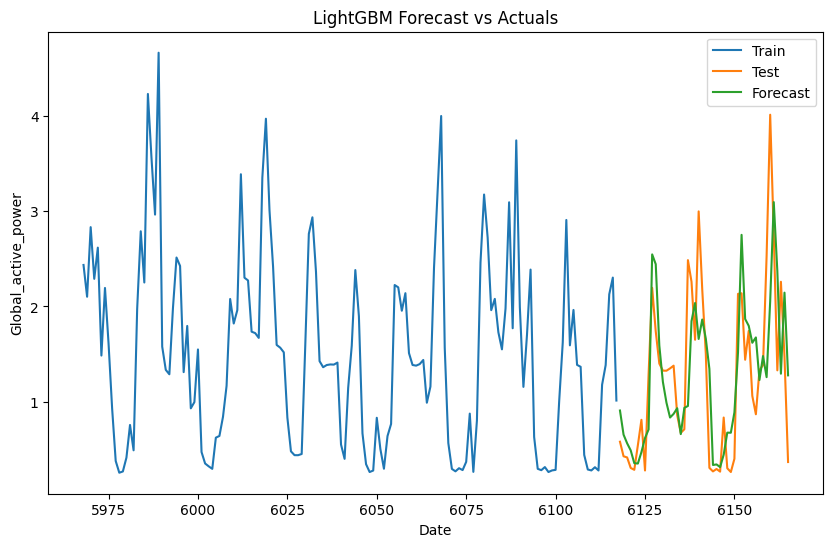

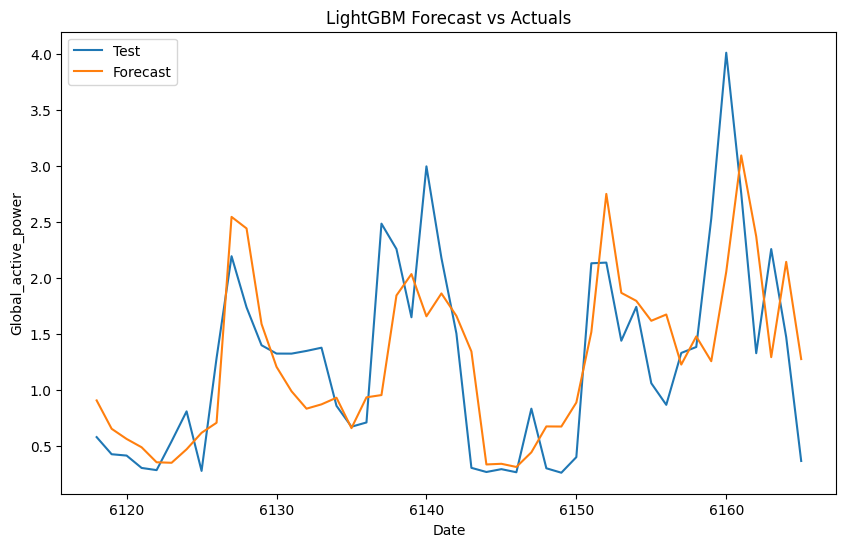

In [0]:
import matplotlib.pyplot as plt

# Initialize a new figure with specified dimensions
plt.figure(figsize=(10, 6))
# Plot the last 150 data points from the training set for visual comparison
plt.plot(train[-150:].index, train[-150:]['Global_active_power'], label='Train')
# Plot all data points from the test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Overlay the predicted values on the test set for comparison
plt.plot(test.index, y_pred, label='Forecast')
# Add a label to the x-axis
plt.xlabel('Date')
# Add a label to the y-axis
plt.ylabel('Global_active_power')
# Set a title for the plot
plt.title('LightGBM Forecast vs Actuals')
# Show a legend to label each line plot
plt.legend()
# Render the plot to the screen
plt.show()

# Start a new figure for plotting test set and forecast only
plt.figure(figsize=(10, 6))
# Plot all data points from the test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Overlay the predicted values on the test set for comparison
plt.plot(test.index, y_pred, label='Forecast')
# Add a label to the x-axis
plt.xlabel('Date')
# Add a label to the y-axis
plt.ylabel('Global_active_power')
# Set a title for the plot
plt.title('LightGBM Forecast vs Actuals')
# Show a legend to label each line plot
plt.legend()
# Render the plot to the screen
plt.show()

#### Experiment 3 - Optuna with joblib (distributed, 30 trials), LightGBM

In [0]:
study3 = optuna.create_study(direction='minimize')
with joblib.parallel_backend("spark", n_jobs=-1):
    study3.optimize(objective, n_trials=30)

[I 2025-03-01 01:18:44,608] A new study created in memory with name: no-name-83ce4a02-758e-4ab4-9b31-3b4a34adfa7f


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:51,262] Trial 0 finished with value: 0.6150872105215801 and parameters: {'n_estimators': 56, 'learning_rate': 0.01492549923775775, 'num_leaves': 50}. Best is trial 0 with value: 0.6150872105215801.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:18:58,170] Trial 1 finished with value: 0.7437111414979759 and parameters: {'n_estimators': 103, 'learning_rate': 0.0027438105434989335, 'num_leaves': 95}. Best is trial 0 with value: 0.6150872105215801.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:05,022] Trial 2 finished with value: 0.779289996821983 and parameters: {'n_estimators': 133, 'learning_rate': 0.0015487433221092384, 'num_leaves': 34}. Best is trial 0 with value: 0.6150872105215801.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:11,785] Trial 3 finished with value: 0.7896926632240685 and parameters: {'n_estimators': 62, 'learning_rate': 0.0028160656694978564, 'num_leaves': 96}. Best is trial 0 with value: 0.6150872105215801.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:18,536] Trial 4 finished with value: 0.5811772064578496 and parameters: {'n_estimators': 155, 'learning_rate': 0.0066073818981044275, 'num_leaves': 84}. Best is trial 4 with value: 0.5811772064578496.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:24,976] Trial 5 finished with value: 0.6246976843962652 and parameters: {'n_estimators': 69, 'learning_rate': 0.011123795721115373, 'num_leaves': 50}. Best is trial 4 with value: 0.5811772064578496.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:31,960] Trial 6 finished with value: 0.5733472317064873 and parameters: {'n_estimators': 62, 'learning_rate': 0.018537172639387367, 'num_leaves': 56}. Best is trial 6 with value: 0.5733472317064873.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:39,142] Trial 7 finished with value: 0.8311085540931856 and parameters: {'n_estimators': 67, 'learning_rate': 0.00131455614894076, 'num_leaves': 100}. Best is trial 6 with value: 0.5733472317064873.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:45,826] Trial 8 finished with value: 0.5180311314405831 and parameters: {'n_estimators': 56, 'learning_rate': 0.07007934020018862, 'num_leaves': 76}. Best is trial 8 with value: 0.5180311314405831.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:52,838] Trial 9 finished with value: 0.6864740513532173 and parameters: {'n_estimators': 188, 'learning_rate': 0.0024839610233460224, 'num_leaves': 46}. Best is trial 8 with value: 0.5180311314405831.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:19:59,709] Trial 10 finished with value: 0.5539154761983954 and parameters: {'n_estimators': 102, 'learning_rate': 0.09415605269826802, 'num_leaves': 78}. Best is trial 8 with value: 0.5180311314405831.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:06,570] Trial 11 finished with value: 0.5430766803643352 and parameters: {'n_estimators': 102, 'learning_rate': 0.09774914575468482, 'num_leaves': 73}. Best is trial 8 with value: 0.5180311314405831.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:13,623] Trial 12 finished with value: 0.5190268791201277 and parameters: {'n_estimators': 96, 'learning_rate': 0.09212622591278574, 'num_leaves': 70}. Best is trial 8 with value: 0.5180311314405831.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:20,362] Trial 13 finished with value: 0.5247188185739474 and parameters: {'n_estimators': 92, 'learning_rate': 0.03875411036339395, 'num_leaves': 66}. Best is trial 8 with value: 0.5180311314405831.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:27,438] Trial 14 finished with value: 0.5169756381232886 and parameters: {'n_estimators': 130, 'learning_rate': 0.042280691870031285, 'num_leaves': 65}. Best is trial 14 with value: 0.5169756381232886.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:34,597] Trial 15 finished with value: 0.5224417433709485 and parameters: {'n_estimators': 137, 'learning_rate': 0.04049568354204317, 'num_leaves': 82}. Best is trial 14 with value: 0.5169756381232886.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:41,603] Trial 16 finished with value: 0.5196778298134314 and parameters: {'n_estimators': 159, 'learning_rate': 0.03494817535751645, 'num_leaves': 60}. Best is trial 14 with value: 0.5169756381232886.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:49,404] Trial 17 finished with value: 0.5176604686350278 and parameters: {'n_estimators': 200, 'learning_rate': 0.05697553991906256, 'num_leaves': 88}. Best is trial 14 with value: 0.5169756381232886.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:20:57,509] Trial 18 finished with value: 0.5186318797827328 and parameters: {'n_estimators': 200, 'learning_rate': 0.020639232467731743, 'num_leaves': 86}. Best is trial 14 with value: 0.5169756381232886.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:04,276] Trial 19 finished with value: 0.49793471464679656 and parameters: {'n_estimators': 172, 'learning_rate': 0.05668256109067843, 'num_leaves': 38}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:10,891] Trial 20 finished with value: 0.5728610596063446 and parameters: {'n_estimators': 169, 'learning_rate': 0.006883454835922823, 'num_leaves': 30}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:19,235] Trial 21 finished with value: 0.519229507973796 and parameters: {'n_estimators': 181, 'learning_rate': 0.056693570361338534, 'num_leaves': 40}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:26,783] Trial 22 finished with value: 0.5122810374254224 and parameters: {'n_estimators': 200, 'learning_rate': 0.02792303818508006, 'num_leaves': 60}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:34,400] Trial 23 finished with value: 0.5130002908079234 and parameters: {'n_estimators': 180, 'learning_rate': 0.028616589048490838, 'num_leaves': 59}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:41,166] Trial 24 finished with value: 0.5181404161576353 and parameters: {'n_estimators': 178, 'learning_rate': 0.02617365184708737, 'num_leaves': 58}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:47,937] Trial 25 finished with value: 0.5199162182247256 and parameters: {'n_estimators': 147, 'learning_rate': 0.026994583348260753, 'num_leaves': 38}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:21:54,801] Trial 26 finished with value: 0.535520534704204 and parameters: {'n_estimators': 168, 'learning_rate': 0.012560304973203125, 'num_leaves': 47}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:22:01,583] Trial 27 finished with value: 0.5046270434287307 and parameters: {'n_estimators': 189, 'learning_rate': 0.02608427643547958, 'num_leaves': 42}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:22:08,056] Trial 28 finished with value: 0.5528998493837071 and parameters: {'n_estimators': 191, 'learning_rate': 0.007412010862013746, 'num_leaves': 41}. Best is trial 19 with value: 0.49793471464679656.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-03-01 01:22:14,555] Trial 29 finished with value: 0.5254850903003209 and parameters: {'n_estimators': 171, 'learning_rate': 0.01939282961558704, 'num_leaves': 52}. Best is trial 19 with value: 0.49793471464679656.


In [0]:
trial = study3.best_trial

print(f"Best trial accuracy: {trial.value}")
print("Best trial params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial accuracy: 0.49793471464679656
Best trial params: 
    n_estimators: 172
    learning_rate: 0.05668256109067843
    num_leaves: 38


In [0]:
final_model = lgb.LGBMRegressor(**trial.params)
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Evaluate the model using MSE, MAE, and MAPE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

Test MSE: 0.3961381031236628
Test MAE: 0.45521150310086816
Test MAPE: 0.49793471464679656


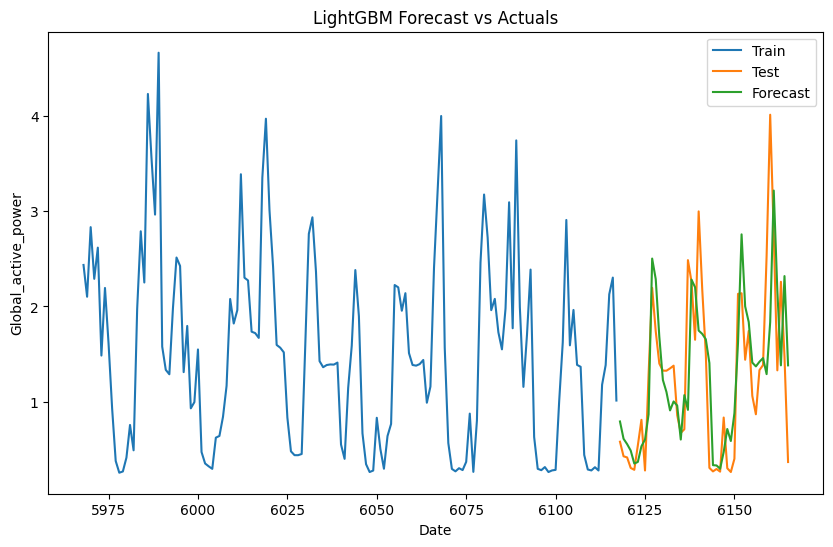

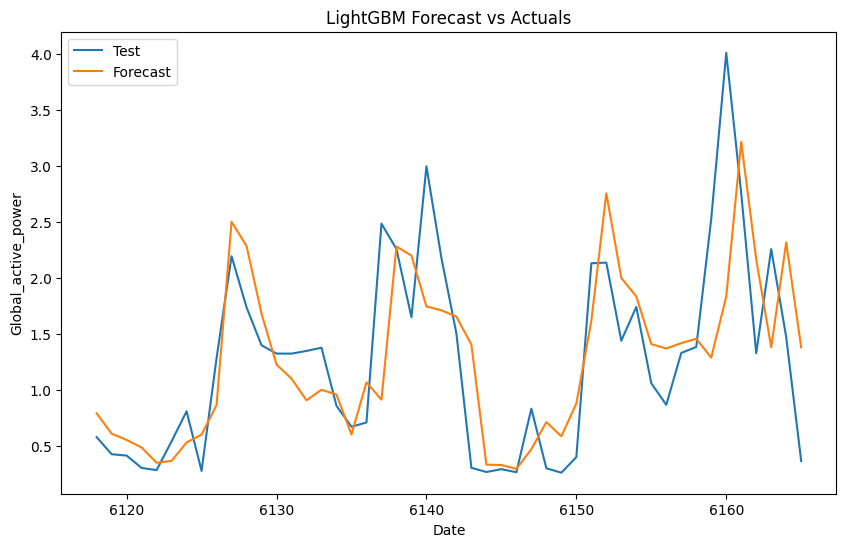

In [0]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))
# Plot the last 150 points of the training set
plt.plot(train[-150:].index, train[-150:]['Global_active_power'], label='Train')
# Plot the entire test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Plot the predicted values for the test set
plt.plot(test.index, y_pred, label='Forecast')
# Label the x-axis as 'Date'
plt.xlabel('Date')
# Label the y-axis as 'Global_active_power'
plt.ylabel('Global_active_power')
# Set the title of the plot
plt.title('LightGBM Forecast vs Actuals')
# Display the legend to differentiate between the plotted lines
plt.legend()
# Display the plot
plt.show()

# Set the size of the plot
plt.figure(figsize=(10, 6))
# Plot the entire test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Plot the predicted values for the test set
plt.plot(test.index, y_pred, label='Forecast')
# Label the x-axis as 'Date'
plt.xlabel('Date')
# Label the y-axis as 'Global_active_power'
plt.ylabel('Global_active_power')
# Set the title of the plot
plt.title('LightGBM Forecast vs Actuals')
# Display the legend to differentiate between the plotted lines
plt.legend()
# Display the plot
plt.show()

#### Experiment 4 - Pandas, TimeSeriesSplit, GridSearchCV, LightGBM

In [0]:
# Split the data into training and testing sets
# The last 48 observations are used for testing, the rest for training
train_pdf = data_hr.filter('cust_id == 1').toPandas()
train = train_pdf[:-48]
test = train_pdf[-48:]

In [0]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Extract features and target variable for training and testing sets
X_train = train[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
y_train = train['Global_active_power']
X_test = test[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
y_test = test['Global_active_power']

# Define the parameter grid for LightGBM
param_grid = {
    'num_leaves': [30, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Initialize LightGBM regressor
lgbm = lgb.LGBMRegressor()

# Setup TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Configure and run GridSearchCV
gsearch = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=tscv)
gsearch.fit(X_train, y_train)

# Output the best parameters from Grid Search
print(f"Best Parameters: {gsearch.best_params_}")

# Train the model with the best parameters found
best_params = gsearch.best_params_
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 558, number of used features: 8
[LightGBM] [Info] Start training from score 1.211219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 30}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Evaluate the model using MSE, MAE, and MAPE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

Test MSE: 0.39902940406072585
Test MAE: 0.45141250254665116
Test MAPE: 0.5449796975370231


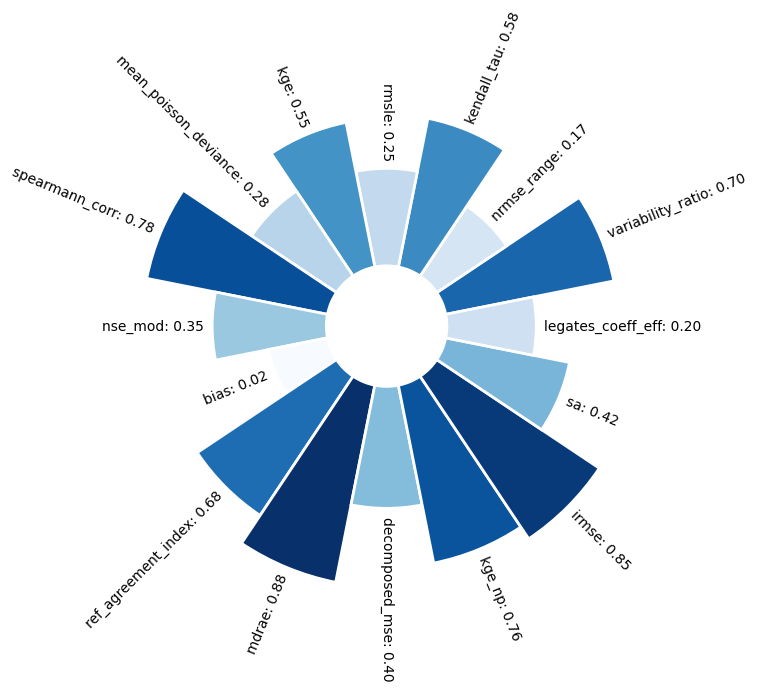

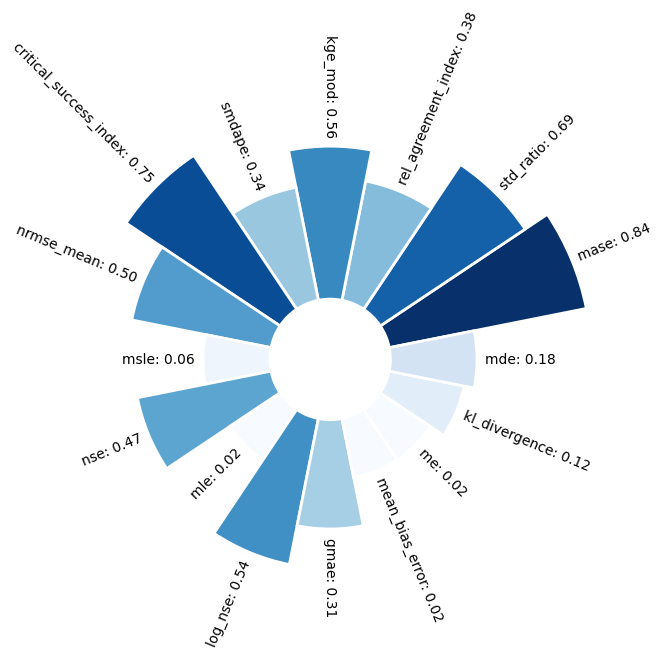

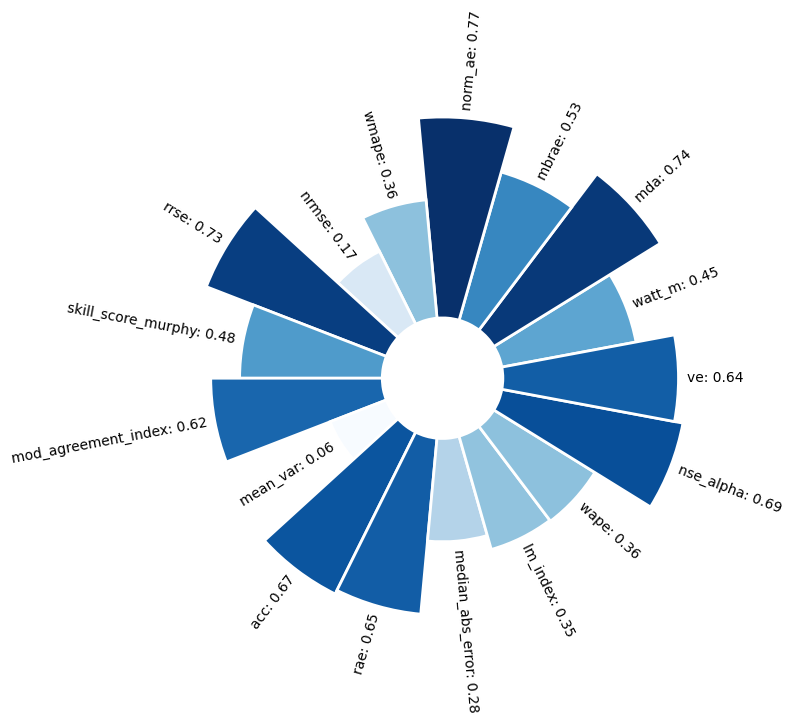

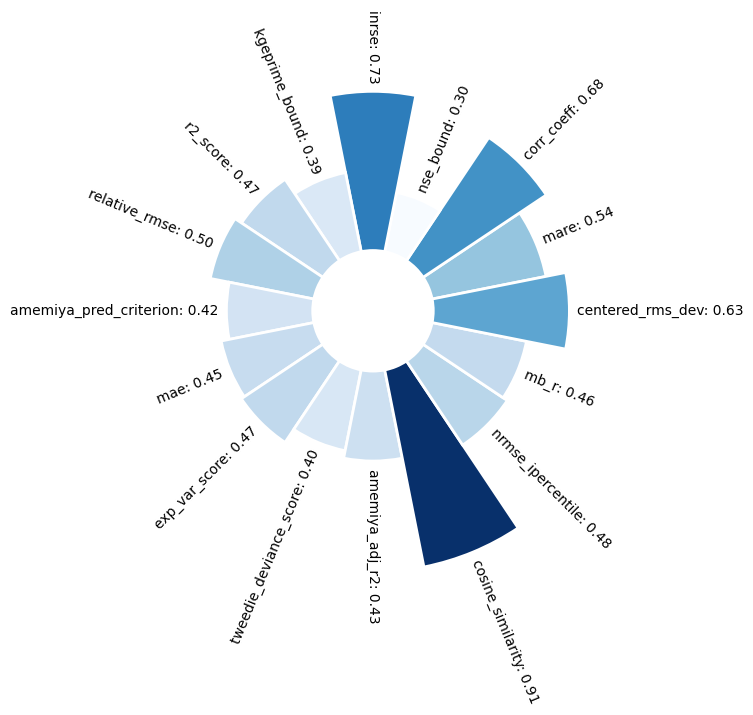

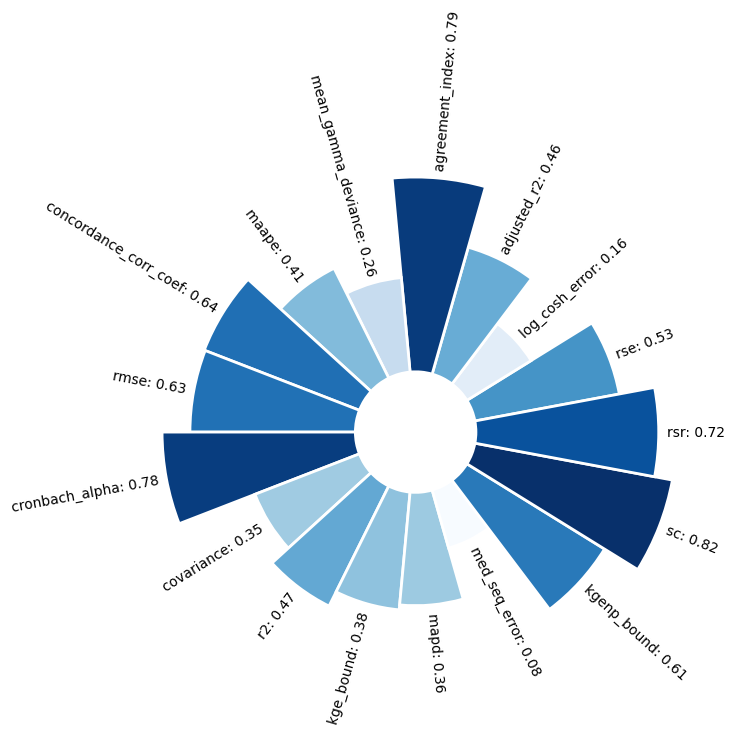

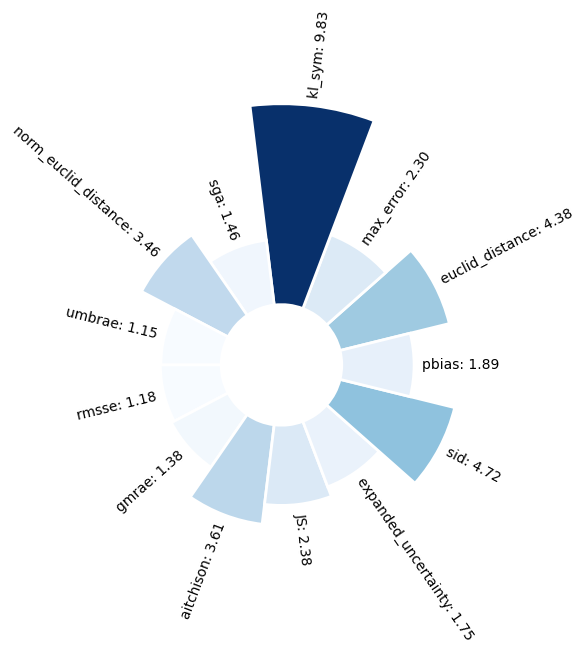

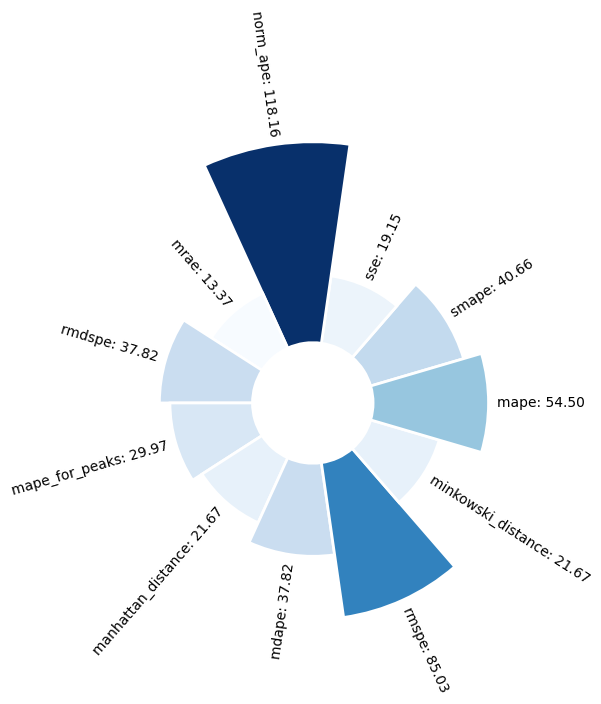

Test SMAPE: 40.657202510815935
Test WAPE: 0.35686490211357236


In [0]:
from SeqMetrics import RegressionMetrics, plot_metrics

# Initialize the RegressionMetrics object with actual and predicted values
er = RegressionMetrics(y_test, y_pred)

# Calculate all available regression metrics
metrics = er.calculate_all()

# Plot the calculated metrics using a color gradient of "Blues"
plot_metrics(metrics, color="Blues")
# Print the Symmetric Mean Absolute Percentage Error (SMAPE)
print(f"Test SMAPE: {metrics['smape']}")
# Print the Weighted Absolute Percentage Error (WAPE)
print(f"Test WAPE: {metrics['wape']}")

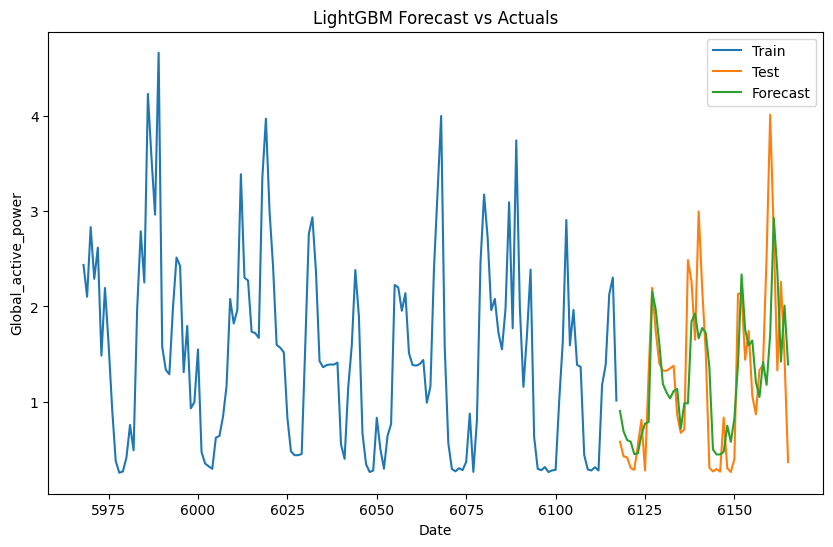

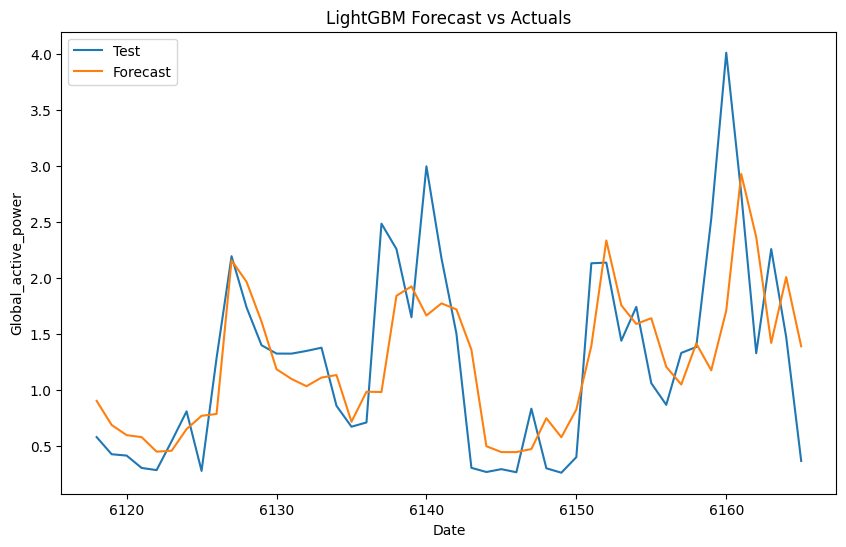

In [0]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))
# Plot the last 150 points of the training set
plt.plot(train[-150:].index, train[-150:]['Global_active_power'], label='Train')
# Plot the entire test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Plot the predicted values for the test set
plt.plot(test.index, y_pred, label='Forecast')
# Label the x-axis as 'Date'
plt.xlabel('Date')
# Label the y-axis as 'Global_active_power'
plt.ylabel('Global_active_power')
# Set the title of the plot
plt.title('LightGBM Forecast vs Actuals')
# Display the legend to differentiate between the plotted lines
plt.legend()
# Display the plot
plt.show()

# Set the size of the plot
plt.figure(figsize=(10, 6))
# Plot the entire test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Plot the predicted values for the test set
plt.plot(test.index, y_pred, label='Forecast')
# Label the x-axis as 'Date'
plt.xlabel('Date')
# Label the y-axis as 'Global_active_power'
plt.ylabel('Global_active_power')
# Set the title of the plot
plt.title('LightGBM Forecast vs Actuals')
# Display the legend to differentiate between the plotted lines
plt.legend()
# Display the plot
plt.show()

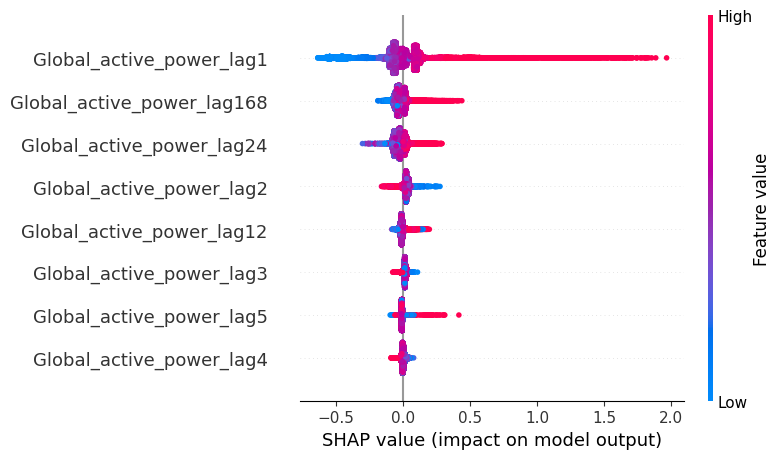

In [0]:
import shap

# Initialize a SHAP TreeExplainer with the trained model
explainer = shap.TreeExplainer(final_model)

# Select features for SHAP analysis
X = data_hr[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']].toPandas()

# Compute SHAP values for the selected features
shap_values = explainer(X)

# Generate and display a summary plot of the SHAP values
shap.summary_plot(shap_values, X)

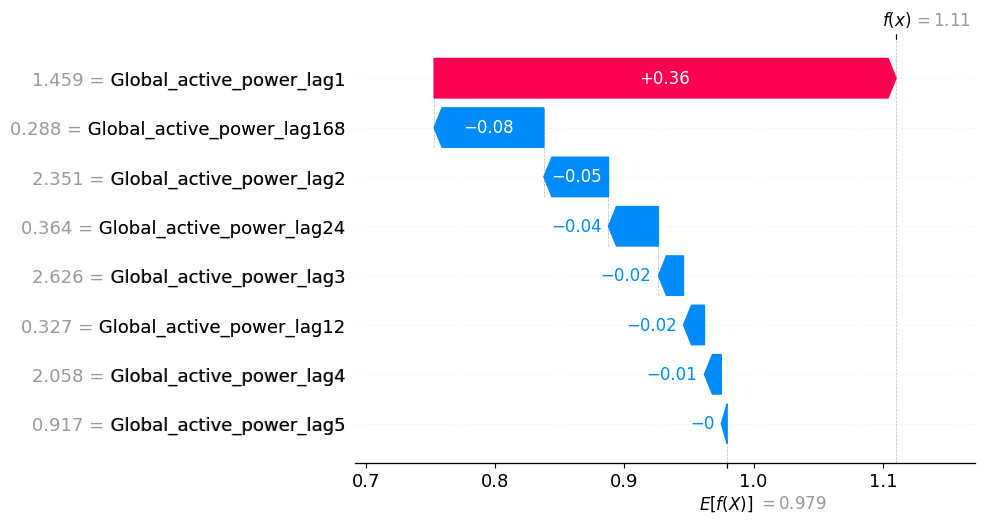

In [0]:
# Plot a SHAP waterfall plot for the first observation's SHAP values to visualize the contribution of each feature
shap.plots.waterfall(shap_values[0])

#### Experiment 5 - Pandas, TimeSeriesSplit, GridSearchCV, LightGBM

In [0]:
# Split the data into training and testing sets
# The last 48 observations are used for testing, the rest for 
train_pdf = data_hr.filter('cust_id == 1').toPandas()
train = train_pdf[:-48]
test = train_pdf[-48:]

In [0]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Extract features and target variable for training and testing sets
X_train = train[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
y_train = train['Global_active_power']
X_test = test[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
y_test = test['Global_active_power']

# Define the parameter grid for LightGBM
param_grid = {
    'num_leaves': [30, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Initialize LightGBM regressor
lgbm = lgb.LGBMRegressor()

# Setup TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Configure and run GridSearchCV
gsearch = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=tscv)
gsearch.fit(X_train, y_train)

# Output the best parameters from Grid Search
print(f"Best Parameters: {gsearch.best_params_}")

# Train the model with the best parameters found
best_params = gsearch.best_params_
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 558, number of used features: 8
[LightGBM] [Info] Start training from score 1.211219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 30}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6118, number of used features: 8
[LightGBM] [Info] Start training from score 0.979441


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Evaluate the model using MSE, MAE, and MAPE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

Test MSE: 0.39902940406072585
Test MAE: 0.45141250254665116
Test MAPE: 0.5449796975370231


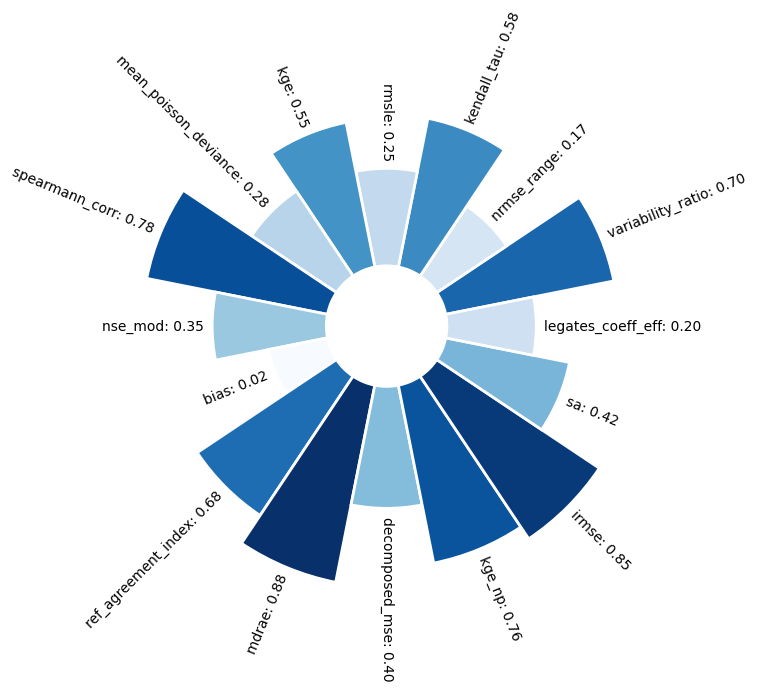

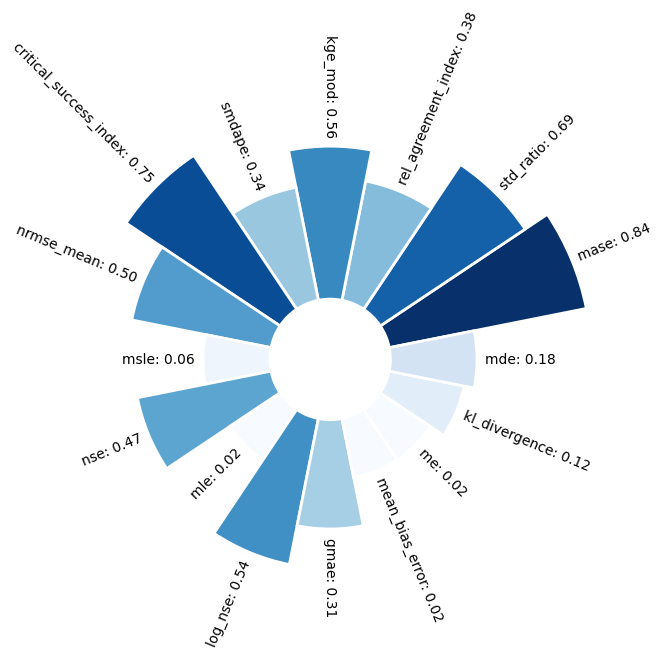

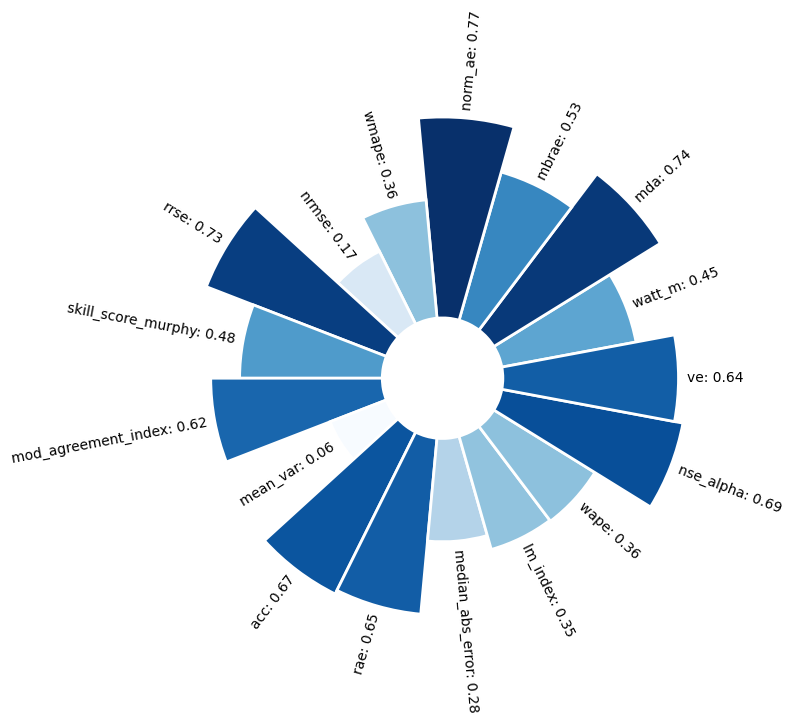

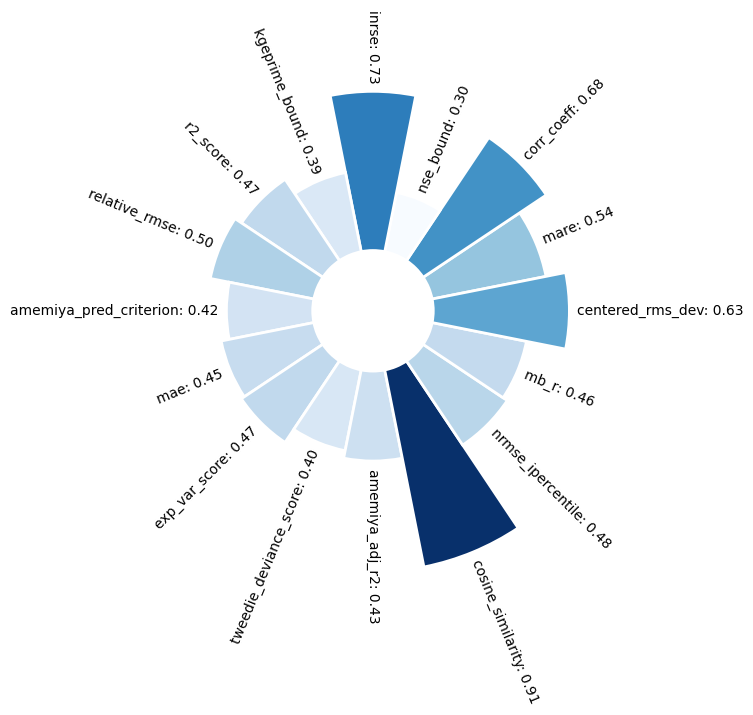

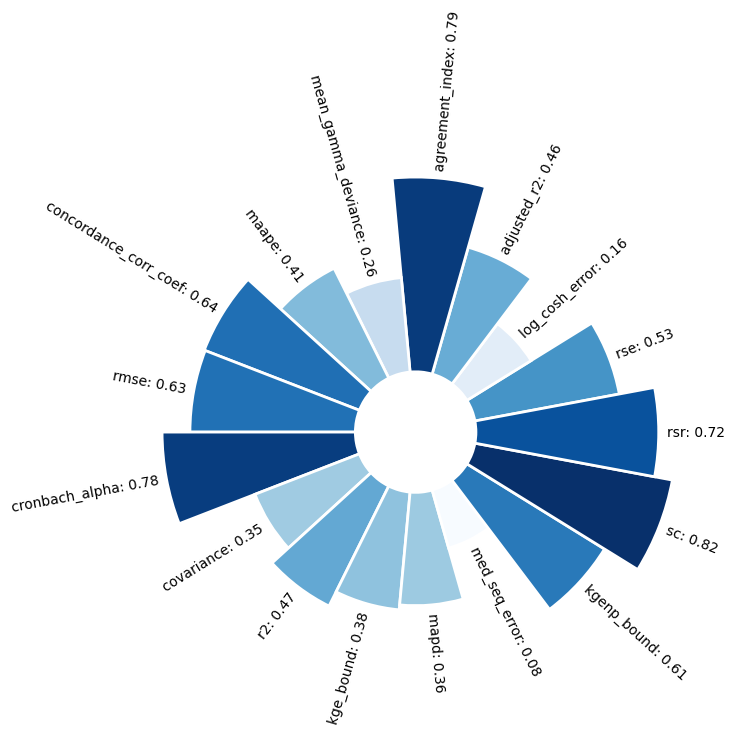

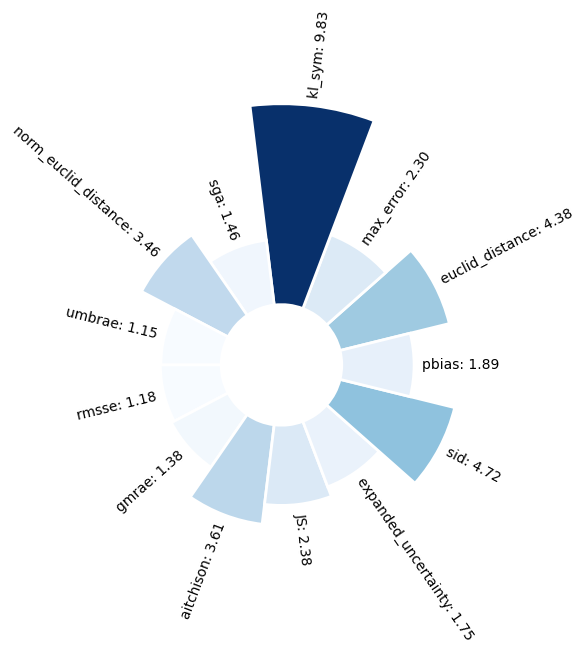

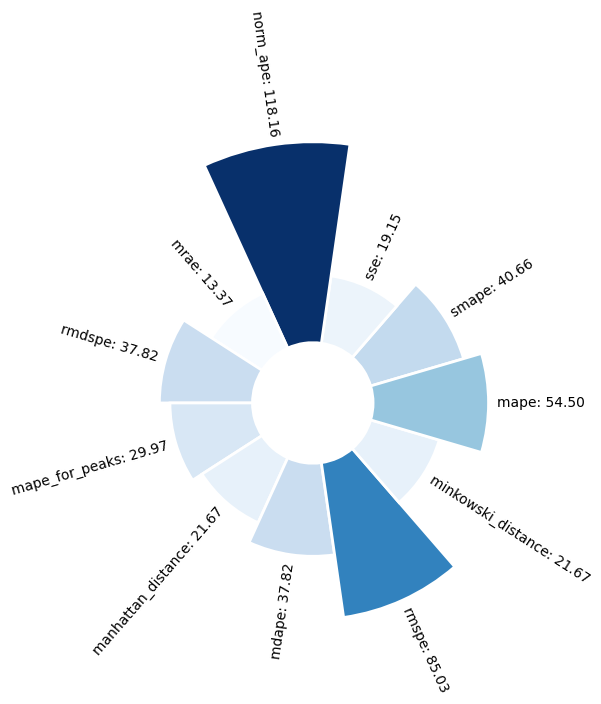

Test SMAPE: 40.657202510815935
Test WAPE: 0.35686490211357236


In [0]:
from SeqMetrics import RegressionMetrics, plot_metrics

# Initialize the RegressionMetrics object with actual and predicted values
er = RegressionMetrics(y_test, y_pred)

# Calculate all available regression metrics
metrics = er.calculate_all()

# Plot the calculated metrics using a color gradient of "Blues"
plot_metrics(metrics, color="Blues")
# Print the Symmetric Mean Absolute Percentage Error (SMAPE)
print(f"Test SMAPE: {metrics['smape']}")
# Print the Weighted Absolute Percentage Error (WAPE)
print(f"Test WAPE: {metrics['wape']}")

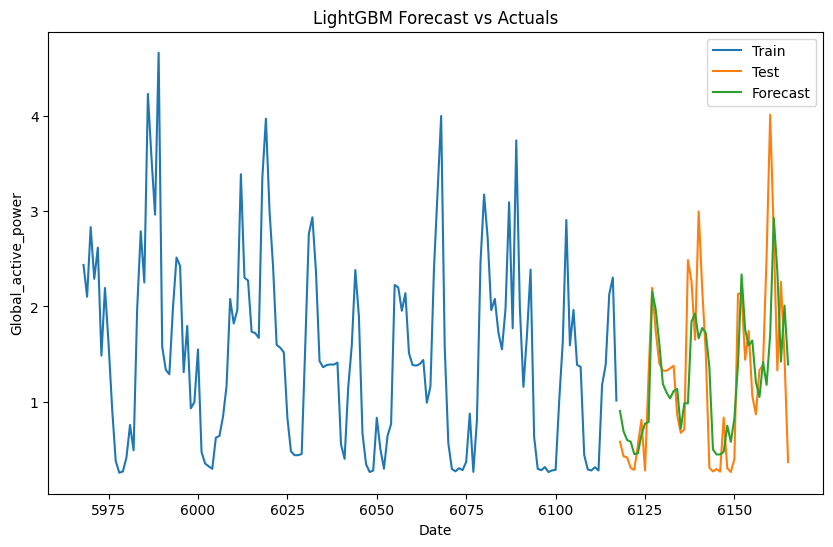

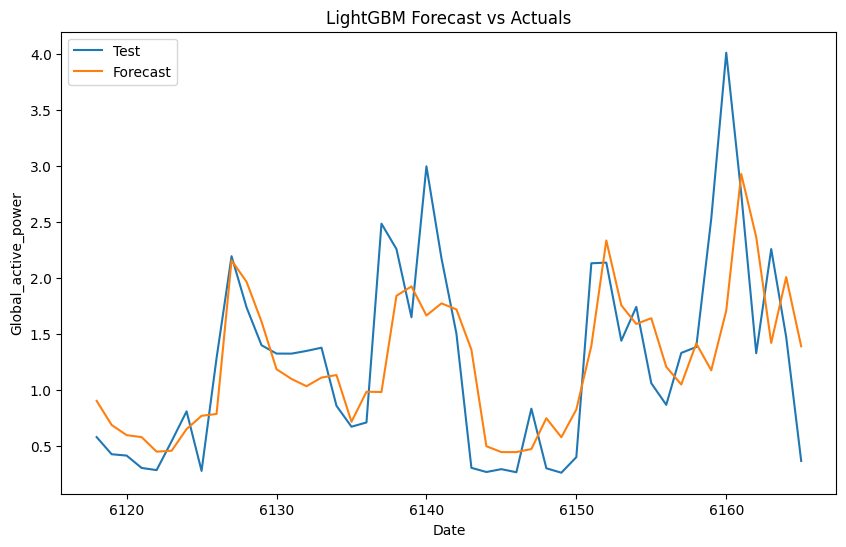

In [0]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))
# Plot the last 150 points of the training set
plt.plot(train[-150:].index, train[-150:]['Global_active_power'], label='Train')
# Plot the entire test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Plot the predicted values for the test set
plt.plot(test.index, y_pred, label='Forecast')
# Label the x-axis as 'Date'
plt.xlabel('Date')
# Label the y-axis as 'Global_active_power'
plt.ylabel('Global_active_power')
# Set the title of the plot
plt.title('LightGBM Forecast vs Actuals')
# Display the legend to differentiate between the plotted lines
plt.legend()
# Display the plot
plt.show()

# Set the size of the plot
plt.figure(figsize=(10, 6))
# Plot the entire test set
plt.plot(test.index, test['Global_active_power'], label='Test')
# Plot the predicted values for the test set
plt.plot(test.index, y_pred, label='Forecast')
# Label the x-axis as 'Date'
plt.xlabel('Date')
# Label the y-axis as 'Global_active_power'
plt.ylabel('Global_active_power')
# Set the title of the plot
plt.title('LightGBM Forecast vs Actuals')
# Display the legend to differentiate between the plotted lines
plt.legend()
# Display the plot
plt.show()


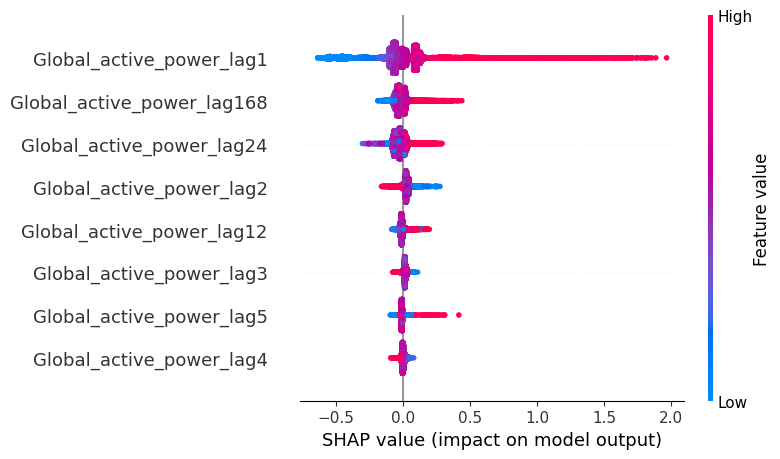

In [0]:
import shap

# Initialize a SHAP TreeExplainer with the trained model
explainer = shap.TreeExplainer(final_model)

# Select features for SHAP analysis
X = data_hr[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']].toPandas()

# Compute SHAP values for the selected features
shap_values = explainer(X)

# Generate and display a summary plot of the SHAP values
shap.summary_plot(shap_values, X)

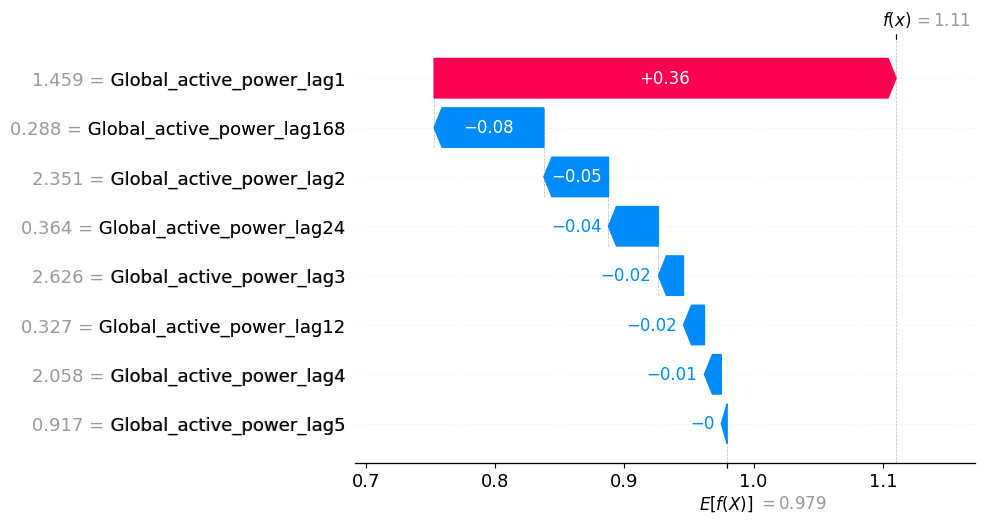

In [0]:
# Plot a SHAP waterfall plot for the first observation's SHAP values to visualize the contribution of each feature
shap.plots.waterfall(shap_values[0])

#### Experiment 6 - VectorAssembler, Pipeline, XGBoost

##### Single model in parallel (book section)

In [0]:
from pyspark.ml.feature import VectorAssembler

# Define a list to hold the names of the lag feature columns
inputCols = []
# Loop through the list of lag intervals to create feature column names
for l in lags:
    inputCols.append('Global_active_power_lag' + str(l))

# Initialize VectorAssembler with the created feature column names and specify the output column name
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
# Transform the data to assemble the features into a vector (commented out as it's an example of usage)
#data_hr_vect = assembler.transform(data_hr).select("cust_id", "Date", "features", "Global_active_power")

# Example of how to sort the transformed data by customer ID and date (commented out as it's an example of usage)
#data_hr_vect = data_hr_vect.orderBy("cust_id", "Date")

In [0]:
from xgboost.spark import SparkXGBRegressor

# Initialize the SparkXGBRegressor for the regression task. 
# `num_workers` is set to the default parallelism level of the Spark context to utilize all available cores.
# `label_col` specifies the target variable column name for prediction.
# `missing` is set to 0.0 to handle missing values in the dataset.
xgb_model = SparkXGBRegressor(num_workers=sc.defaultParallelism, label_col="Global_active_power", missing=0.0)

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the parameter grid for hyperparameter tuning
# - max_depth: specifies the maximum depth of the trees in the model
# - n_estimators: defines the number of trees in the ensemble
paramGrid = ParamGridBuilder()\
  .addGrid(xgb_model.max_depth, [5, 10])\
  .addGrid(xgb_model.n_estimators, [30, 100])\
  .build()

# Initialize the regression evaluator for model evaluation
# - metricName: specifies the metric to use for evaluation, here RMSE (Root Mean Squared Error)
# - labelCol: the name of the label column
# - predictionCol: the name of the prediction column
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol=xgb_model.getLabelCol(),
                                predictionCol=xgb_model.getPredictionCol())

# Initialize the CrossValidator for hyperparameter tuning
# - estimator: the model to be tuned
# - evaluator: the evaluator to be used for model evaluation
# - estimatorParamMaps: the grid of parameters to be used for tuning
cv = CrossValidator(estimator=xgb_model, evaluator=evaluator, estimatorParamMaps=paramGrid)

In [0]:
from pyspark.ml import Pipeline

# Initialize a Pipeline object with two stages: a feature assembler and a cross-validator for model tuning
pipeline = Pipeline(stages=[assembler, cv])

In [0]:
# Filter the dataset for customer with cust_id equal to 1
train_hr = data_hr.filter('cust_id == 1')

# Create a Spark DataFrame excluding the last 48 records for training
train_hr = spark.createDataFrame(train_hr.head(train_hr.count() - 48))

# Fit the pipeline model to the training data
pipelineModel = pipeline.fit(train_hr)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 4 workers with
	booster params: {'device': 'cpu', 'max_depth': 5, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 30}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 4 workers with
	booster params: {'device': 'cpu', 'max_depth': 5, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 4 workers with
	booster params: {'device': 'cpu', 'max_depth': 10, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 30}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-P

In [0]:
# Filter the dataset for customer with cust_id equal to 1 for testing
test_hr = data_hr.filter('cust_id == 1')
# Create a Spark DataFrame including the last 48 records for testing
test_hr = spark.createDataFrame(train_hr.tail(48))
# The following lines are commented out as they are not used in this snippet
#X_test = test_hr.select('Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168')
#y_test = test_hr.select('Global_active_power')
# Apply the trained pipeline model to the test data to generate predictions
predictions = pipelineModel.transform(test_hr)

In [0]:
# Evaluate the model's performance using the Root Mean Squared Error (RMSE) metric
rmse = evaluator.evaluate(predictions)
# Print the calculated RMSE to assess the model's prediction accuracy
print("Test RMSE: %g" % rmse)

Test RMSE: 0.470557


In [0]:
# Convert the 'Global_active_power' column from the test DataFrame to a Pandas DataFrame for evaluation
y_test = test_hr.select('Global_active_power').toPandas()
# Convert the 'prediction' column from the predictions DataFrame to a Pandas DataFrame for evaluation
y_pred = predictions.select('prediction').toPandas()

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse = mean_squared_error(y_test, y_pred)
# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae = mean_absolute_error(y_test, y_pred)
# Calculate Mean Absolute Percentage Error (MAPE) between actual and predicted values
mape = mean_absolute_percentage_error(y_test, y_pred)
# Display the calculated MSE, MAE, and MAPE to evaluate model performance
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

Test MSE: 0.2214242230679148
Test MAE: 0.3433097841735515
Test MAPE: 0.35684823262623766


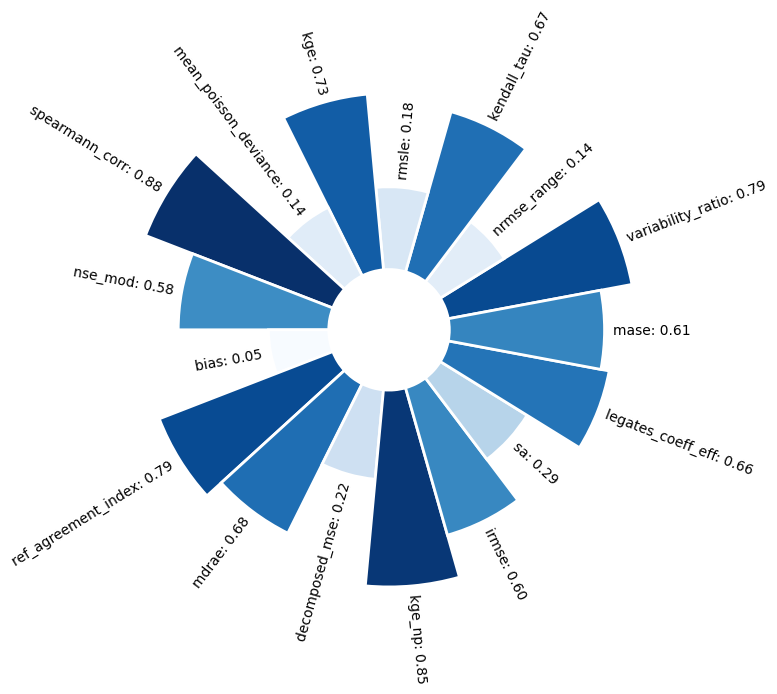

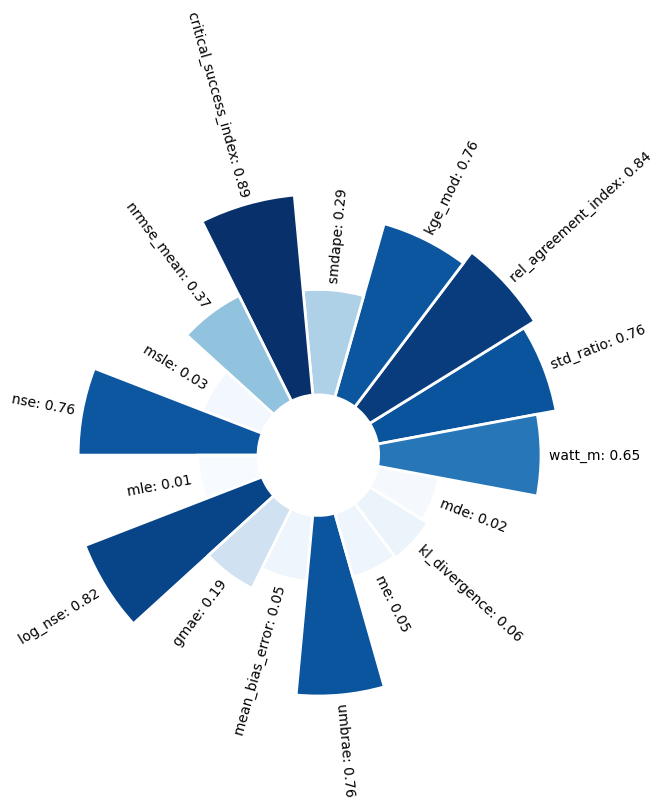

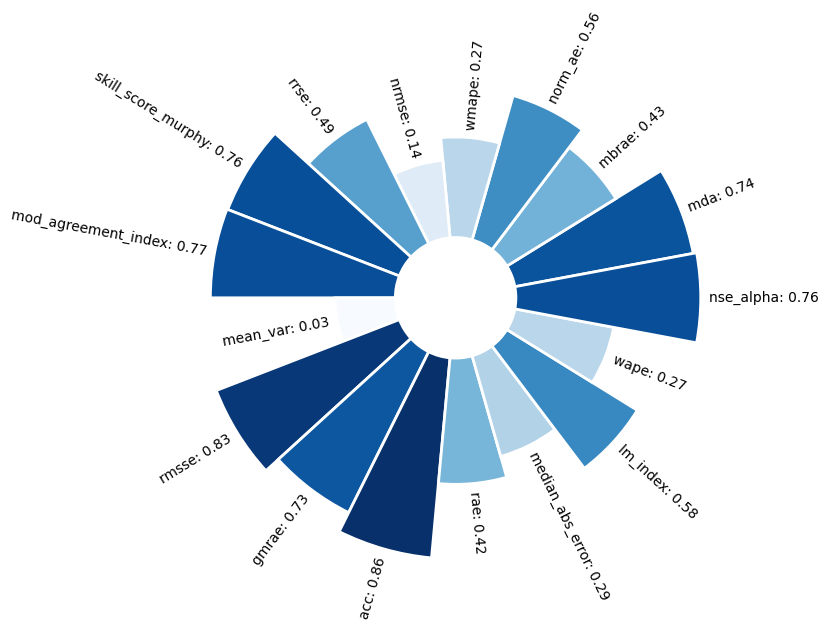

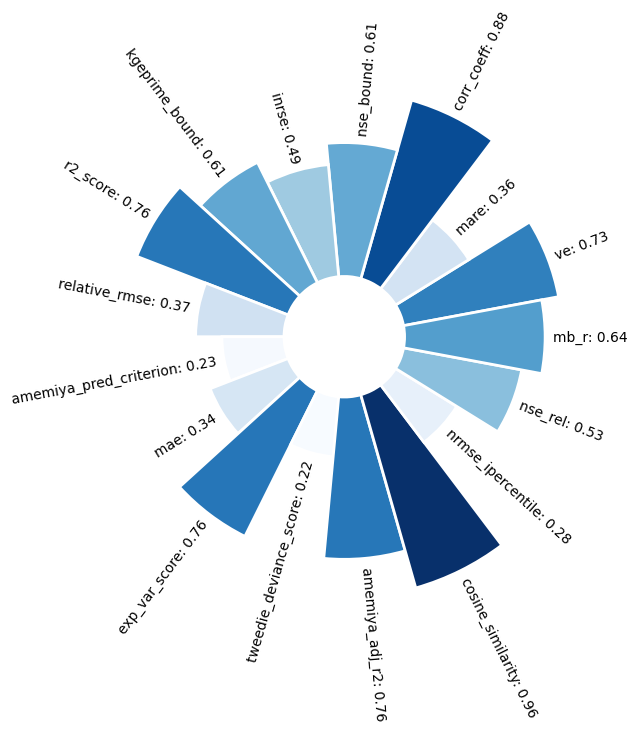

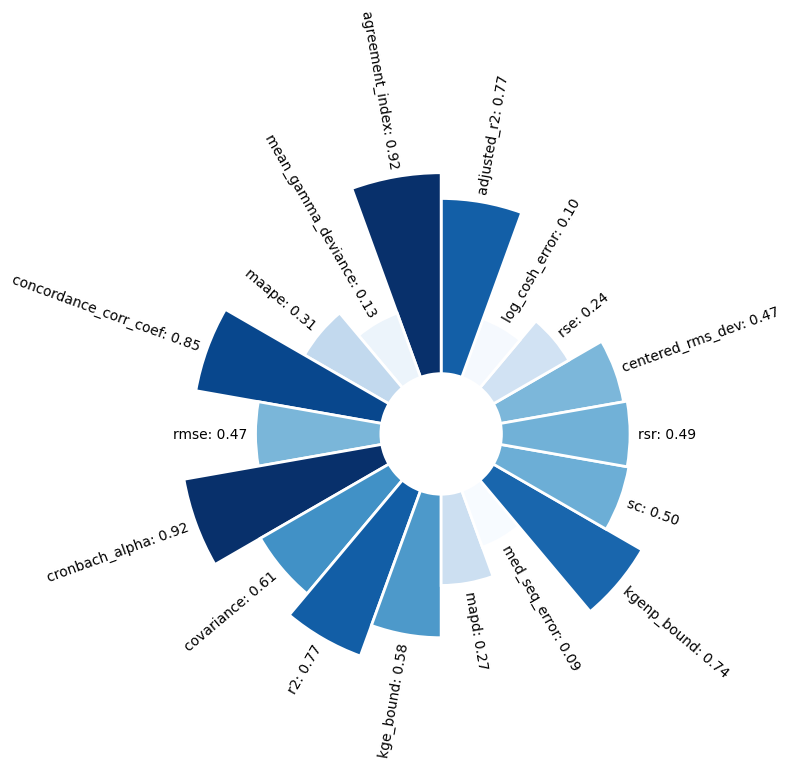

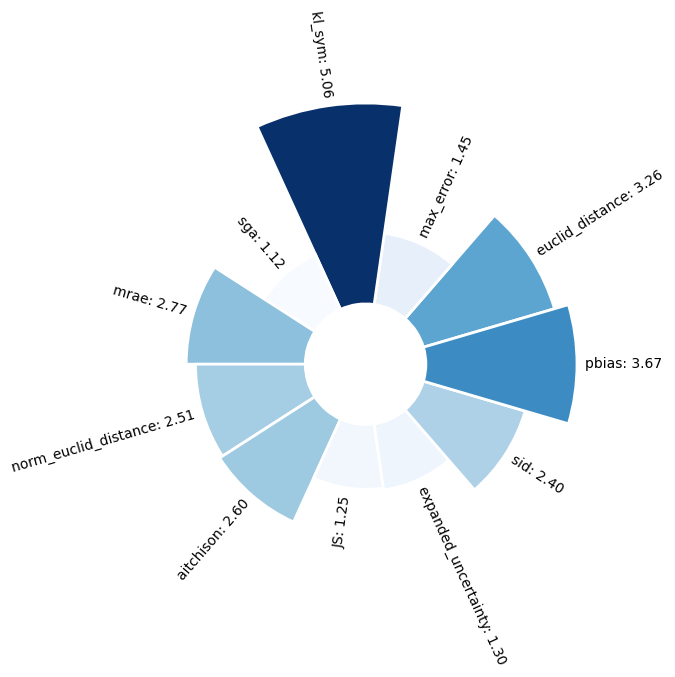

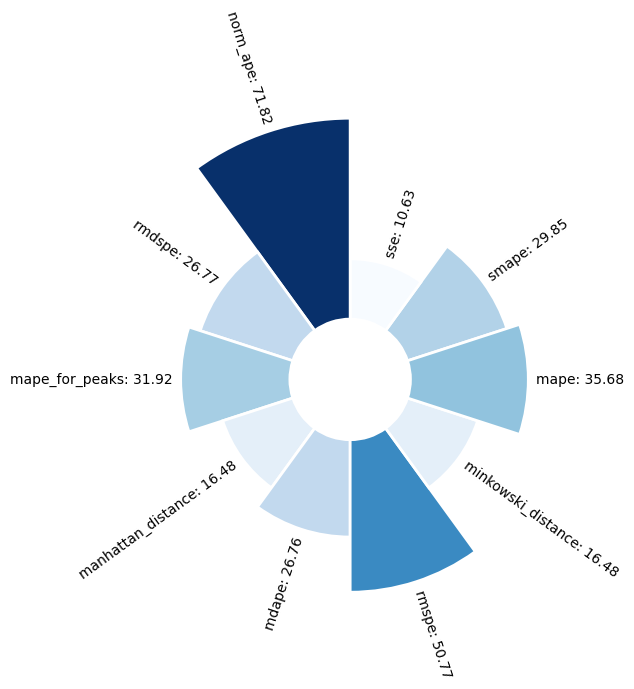

Test SMAPE: 29.84670496760891
Test WAPE: 0.26875737481449524


In [0]:
from SeqMetrics import RegressionMetrics, plot_metrics

# Initialize the RegressionMetrics object with actual (y_test) and predicted (y_pred) values
er = RegressionMetrics(y_test, y_pred)

# Calculate all available regression metrics and store them in the variable 'metrics'
metrics = er.calculate_all()

# Plot the calculated metrics using a color gradient of "Blues"
plot_metrics(metrics, color="Blues")

# Print the Symmetric Mean Absolute Percentage Error (SMAPE) from the calculated metrics
print(f"Test SMAPE: {metrics['smape']}")

# Print the Weighted Absolute Percentage Error (WAPE) from the calculated metrics
print(f"Test WAPE: {metrics['wape']}")

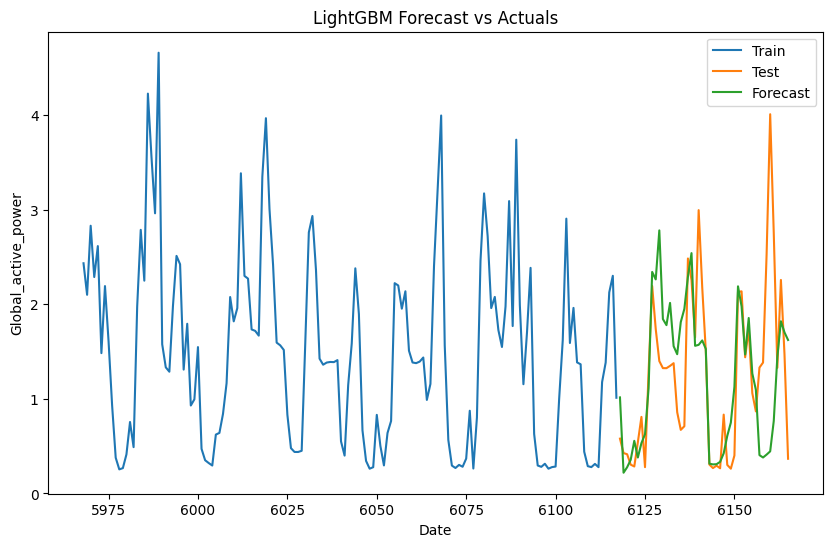

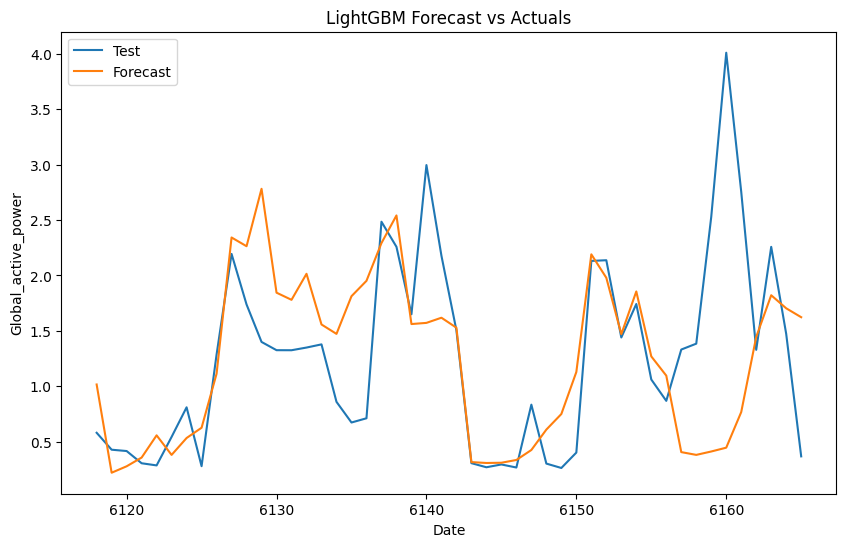

In [0]:
import matplotlib.pyplot as plt

# Initialize a figure with a specified size for plotting training and test data
plt.figure(figsize=(10, 6))
# Plot the last 150 data points from the training set to visualize recent trends
plt.plot(train[-150:].index, train[-150:]['Global_active_power'], label='Train')
# Plot the entire test dataset to compare against the forecast
plt.plot(test.index, test['Global_active_power'], label='Test')
# Overlay the forecasted values on the test dataset for direct comparison
plt.plot(test.index, y_pred, label='Forecast')
# Add a label to the x-axis indicating the data represents dates
plt.xlabel('Date')
# Add a label to the y-axis indicating the data represents global active power consumption
plt.ylabel('Global_active_power')
# Set a title for the plot to indicate it shows a forecast comparison
plt.title('LightGBM Forecast vs Actuals')
# Add a legend to the plot to identify the train, test, and forecast lines
plt.legend()
# Render the plot to display it
plt.show()

# Initialize a second figure with a specified size for plotting test data and forecast
plt.figure(figsize=(10, 6))
# Plot the entire test dataset to show actual consumption
plt.plot(test.index, test['Global_active_power'], label='Test')
# Overlay the forecasted values on the test dataset for evaluation
plt.plot(test.index, y_pred, label='Forecast')
# Add a label to the x-axis indicating the data represents dates
plt.xlabel('Date')
# Add a label to the y-axis indicating the data represents global active power consumption
plt.ylabel('Global_active_power')
# Set a title for the plot to indicate it shows a forecast comparison
plt.title('LightGBM Forecast vs Actuals')
# Add a legend to the plot to identify the test and forecast lines
plt.legend()
# Render the plot to display it
plt.show()

#### Experiment 7 - applyInPandas, LightGBM

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

train_model_result_schema = StructType([
  StructField("cust_id", IntegerType()),
  StructField("rmse", FloatType()),
  StructField("mape", FloatType())          
])

In [0]:
import mlflow.sklearn
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

def train_model(df_pandas: pd.DataFrame) -> pd.DataFrame:
  """
  Trains LGBMRegressor model on a group of data 
  """
  #collect information about the current DataFrame that is being processed
  #get the cust_id for which model is being trained
  cust_id = df_pandas["cust_id"].iloc[0]
  
  # Create the Gradient Boosting Regression model
  #gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=12)
  lgbm = lgb.LGBMRegressor()

  # Define features to train on and the label
  X = df_pandas[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
  y = df_pandas['Global_active_power']

  # Split the data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False, random_state=12)

  # Train the model on the training data
  #gbr.fit(X_train, y_train)
  lgbm.fit(X_train, y_train)

  # Evaluate model
  #y_pred = gbr.predict(X_test)
  y_pred = lgbm.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
  mape = mean_absolute_percentage_error(y_test, y_pred)
  
  return_df = pd.DataFrame([[cust_id, rmse, mape]], 
        columns=["cust_id", "rmse", "mape"])

  return return_df 

In [0]:
from pyspark.sql.functions import lit
#explicitly set the experiment for the model trainings we are going to perform
train_model_result_df = (data_hr
                          .groupby("cust_id")
                          .applyInPandas(train_model, schema=train_model_result_schema)
                          .cache()
)

display(train_model_result_df.orderBy('cust_id'))

cust_id,rmse,mape
1,0.6627018,0.43687797
2,0.13985625,0.11114727
3,0.13907066,0.11248075
4,0.14151043,0.11244513
5,0.14076822,0.11371252


#### Experiment 8 - applyInPandas, TimeSeriesSplit, GridSearchCV, LightGBM

##### Multiple models in parallel (book section)

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

# Define the schema for the DataFrame that will store information about trained models
train_model_result_schema = StructType([
  StructField("cust_id", IntegerType()),  # Customer ID as an integer
  StructField("best_params", StringType()),  # Best parameters found during model tuning, stored as a string
  StructField("rmse", FloatType()),  # Root Mean Squared Error of the model predictions, as a float
  StructField("mape", FloatType())  # Mean Absolute Percentage Error of the model predictions, as a float          
])

In [0]:
import mlflow.sklearn
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

def train_model(df_pandas: pd.DataFrame) -> pd.DataFrame:
    # Extract the customer ID for which the model is being trained
    cust_id = df_pandas["cust_id"].iloc[0]
    
    # Select features and target variable from the DataFrame
    X = df_pandas[['Global_active_power_lag1', 'Global_active_power_lag2', 'Global_active_power_lag3', 'Global_active_power_lag4', 'Global_active_power_lag5', 'Global_active_power_lag12', 'Global_active_power_lag24', 'Global_active_power_lag168']]
    y = df_pandas['Global_active_power']

    # Split the dataset into training and testing sets, preserving time order
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=12)

    # Define the hyperparameter space for LightGBM model tuning
    param_grid = {
        'num_leaves': [30, 50, 100],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [50, 100, 200]
    }

    # Initialize the LightGBM regressor model
    lgbm = lgb.LGBMRegressor()

    # Initialize TimeSeriesSplit for cross-validation to respect time series data structure
    tscv = TimeSeriesSplit(n_splits=10)

    # Perform grid search with cross-validation
    gsearch = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=tscv)
    gsearch.fit(X_train, y_train)

    # Extract the best hyperparameters
    best_params = gsearch.best_params_

    # Train the final model using the best parameters
    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)
    # Calculate RMSE and MAPE metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Prepare the results DataFrame to return
    return_df = pd.DataFrame([[cust_id, str(best_params), rmse, mape]], 
                             columns=["cust_id", "best_params", "rmse", "mape"])

    return return_df

In [0]:
from pyspark.sql.functions import lit

# Group the data by customer ID and apply the train_model function to each group using Pandas UDF
# The schema for the resulting DataFrame is defined by trained_models_info_schema
# Cache the resulting DataFrame to optimize performance for subsequent actions
train_model_result_df = (data_hr
                          .groupby("cust_id")
                          .applyInPandas(train_model, schema=train_model_result_schema)
                          .cache()
)

# Display the model training information DataFrame, ordered by customer ID
display(train_model_result_df.orderBy('cust_id'))

cust_id,best_params,rmse,mape
1,"{'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 30}",0.6458537,0.4390435
2,"{'learning_rate': 0.001, 'n_estimators': 50, 'num_leaves': 50}",0.13758793,0.10998917
3,"{'learning_rate': 0.001, 'n_estimators': 50, 'num_leaves': 30}",0.1344799,0.10816919
4,"{'learning_rate': 0.001, 'n_estimators': 50, 'num_leaves': 30}",0.13685308,0.10822027
5,"{'learning_rate': 0.001, 'n_estimators': 50, 'num_leaves': 100}",0.13947318,0.11281624
